In [ ]:
import os
import json
from pathlib import Path
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [ ]:

from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 #====================== Paths ======================
base_path = "/content/drive/MyDrive/pneumonia detectio sytem/dataset/chest_xray"
train_dir = Path(os.path.join(base_path, "train"))
val_dir = Path(os.path.join(base_path, "val"))
test_dir = Path(os.path.join(base_path, "test"))

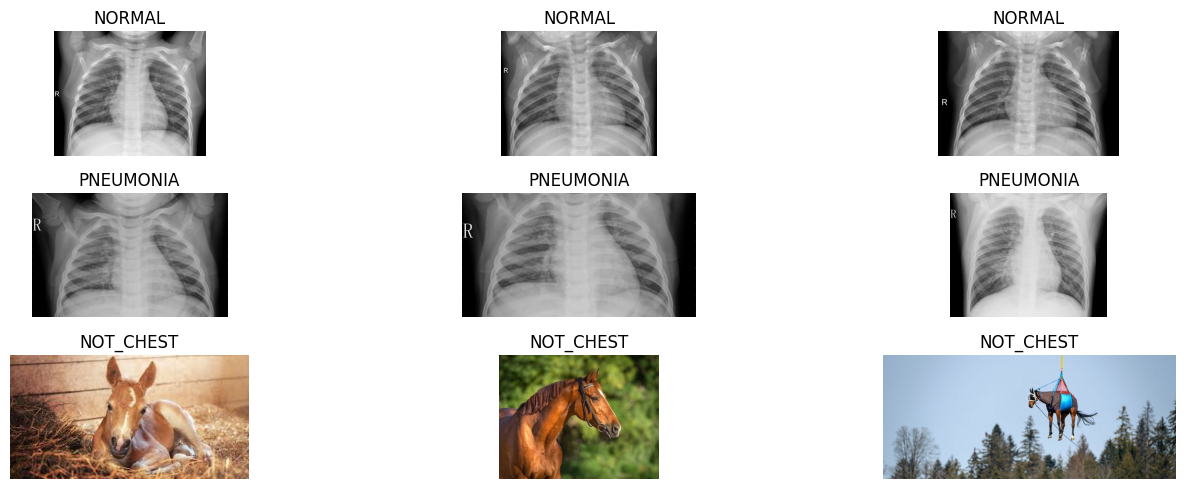

In [ ]:
# ====================== Display Sample Images ======================
def display_images(folder, num=3):
    classes = ['NORMAL', 'PNEUMONIA', 'NOT_CHEST']
    extensions = ['*.jpeg', '*.jpg', '*.png', '*.JPEG', '*.JPG', '*.PNG']
    fig, axes = plt.subplots(nrows=len(classes), ncols=num, figsize=(15, 5))
    for row, cls in enumerate(classes):
        class_path = folder / cls
        images = []
        for ext in extensions:
            images.extend(class_path.glob(ext))
        images = images[:num]
        for i in range(num):
            if i < len(images):
                img = Image.open(images[i])
                axes[row, i].imshow(img, cmap='gray')
                axes[row, i].set_title(cls)
                axes[row, i].axis('off')
            else:
                axes[row, i].axis('off')
    plt.tight_layout()
    plt.show()

display_images(train_dir)


In [ ]:
# ====================== Transforms ======================
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
# ====================== Load Data ======================
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# ====================== Compute Class Weights ======================
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.targets),
    y=train_dataset.targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
# ====================== Load ViT Model ======================
config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
config.num_labels = 3

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k", config=config
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.amp import autocast  # For mixed precision training
from torch.cuda.amp import GradScaler  # Scales gradients to avoid underflow during AMP

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20):
    # Lists to store losses and accuracies for each epoch
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []



    for epoch in range(num_epochs):
        print(f"\n📘 Epoch {epoch+1}/{num_epochs}")
        model.train()  # Set model to training mode
        running_loss, correct, total = 0.0, 0, 0  # Track training loss and accuracy

        # ---------- TRAINING LOOP ----------
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            optimizer.zero_grad()  # Clear previous gradients

            # Forward pass with automatic mixed precision
            with autocast(device_type=device.type):
                outputs = model(images).logits  # Forward pass (ViT model returns .logits)
                loss = criterion(outputs, labels)  # Compute loss

            # Backpropagation using scaled loss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)  # Accumulate loss
            _, preds = outputs.max(1)  # Get class predictions
            correct += (preds == labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Count total samples

        # Compute average training loss and accuracy
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # ---------- VALIDATION LOOP ----------
        model.eval()  # Set model to evaluation mode
        val_loss, correct, total = 0.0, 0, 0
        all_preds, all_labels = [], []  # Store predictions and labels for metrics

        with torch.no_grad():  # Disable gradient calculation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images).logits  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item() * images.size(0)

                _, preds = outputs.max(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())  # Save predictions
                all_labels.extend(labels.cpu().numpy())  # Save true labels

        # Compute average validation loss and accuracy
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Compute additional metrics (for multi-class classification)
        val_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Print results for this epoch
        print(f"✅ Epoch {epoch+1} | Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}% | "
              f"Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1: {val_f1:.2f}")


    # Return the model and all metrics for further analysis or plotting
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
# ====================== Train Model ======================
trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=20
)

/tmp/ipython-input-10-3235713156.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))



📘 Epoch 1/20


✅ Epoch 1 | Train Acc: 94.01%, Val Acc: 99.79% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 2/20


✅ Epoch 2 | Train Acc: 97.44%, Val Acc: 99.38% | Precision: 1.00, Recall: 0.99, F1: 0.99

📘 Epoch 3/20


✅ Epoch 3 | Train Acc: 97.54%, Val Acc: 99.59% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 4/20


✅ Epoch 4 | Train Acc: 98.21%, Val Acc: 99.79% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 5/20


✅ Epoch 5 | Train Acc: 98.42%, Val Acc: 100.00% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 6/20


✅ Epoch 6 | Train Acc: 98.42%, Val Acc: 100.00% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 7/20


✅ Epoch 7 | Train Acc: 98.65%, Val Acc: 100.00% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 8/20


✅ Epoch 8 | Train Acc: 98.42%, Val Acc: 100.00% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 9/20


✅ Epoch 9 | Train Acc: 98.65%, Val Acc: 99.17% | Precision: 0.99, Recall: 0.99, F1: 0.99

📘 Epoch 10/20


✅ Epoch 10 | Train Acc: 99.01%, Val Acc: 100.00% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 11/20


✅ Epoch 11 | Train Acc: 98.82%, Val Acc: 100.00% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 12/20


✅ Epoch 12 | Train Acc: 98.97%, Val Acc: 100.00% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 13/20


✅ Epoch 13 | Train Acc: 99.12%, Val Acc: 98.96% | Precision: 0.99, Recall: 0.99, F1: 0.99

📘 Epoch 14/20


✅ Epoch 14 | Train Acc: 98.63%, Val Acc: 99.79% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 15/20


✅ Epoch 15 | Train Acc: 98.70%, Val Acc: 99.79% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 16/20


✅ Epoch 16 | Train Acc: 99.26%, Val Acc: 100.00% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 17/20


✅ Epoch 17 | Train Acc: 99.18%, Val Acc: 99.79% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 18/20


✅ Epoch 18 | Train Acc: 99.26%, Val Acc: 100.00% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 19/20


✅ Epoch 19 | Train Acc: 98.95%, Val Acc: 99.59% | Precision: 1.00, Recall: 1.00, F1: 1.00

📘 Epoch 20/20


✅ Epoch 20 | Train Acc: 99.24%, Val Acc: 100.00% | Precision: 1.00, Recall: 1.00, F1: 1.00


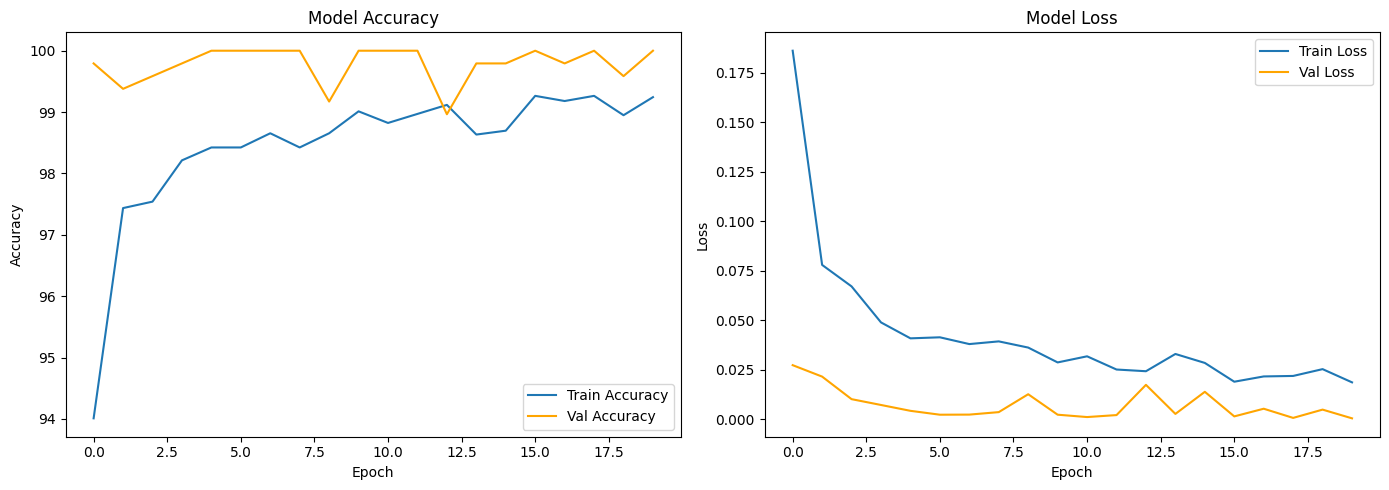

In [ ]:
# ====================== Plot Accuracy & Loss ======================
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.tight_layout()
plt.show()


📊 Test Accuracy: 95.05%
🔍 Precision: 0.9507
🔍 Recall:    0.9505
🔍 F1 Score:  0.9505


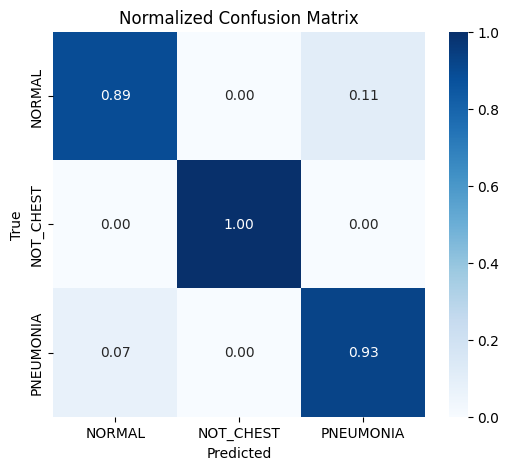

In [ ]:
# ====================== Evaluate with Confusion Matrix ======================
def evaluate_model_with_confusion(model, test_loader, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = outputs.max(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = 100 * sum(p == t for p, t in zip(y_pred, y_true)) / len(y_true)
    print(f"\n📊 Test Accuracy: {acc:.2f}%")
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"🔍 Precision: {precision:.4f}")
    print(f"🔍 Recall:    {recall:.4f}")
    print(f"🔍 F1 Score:  {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
                annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix")
    plt.show()

evaluate_model_with_confusion(trained_model, test_loader, class_names=train_dataset.classes)